<center>
    COMP4240/5435 - Reinforcement Learning

# Homework 3 - Dynamic Programming

    
</center>

Student Name: _____Harshal Dafade_____ 

The purpose of this project is to study different properties of dynamic programming methods. 

In [22]:
# You are allowed to use the following modules
import numpy as np

**Notes:**
- Avoid including magical numbers in your code. Instead, define constants and use meaningful variable names.
- In python, you can pass a function as another function's argument.
- It would be very useful to test each function thouroughly and making sure it does what it is supposed to do, before moving to the next step.
  
**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone.
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

## Part I - Deterministic Clearnig Robot [40 pts]
Consider a cleaning robot that must collect an empty can and also has to recharge its batteries.
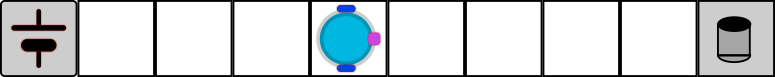

This problem has a discrete state space $S=\{0,…,9\}$, where state $s$ describes the position of the robot in the corridor. The robot has only two actions $A=\{-1,1\}$ for going one step to the left or right. States $0$ and $9$ are terminal, meaning that once the robot reaches either of them it can no longer leave, regardless of the action, and the episode ends. We assume this is a deterministic environment with $\gamma=0.9$.



### I.1 [5 pts]
Write a function that describes the transition function $s'=T(s,a)$ and test it for a few state-action pairs including terminal states. This is a deterministic transition function meaning given the current state and action, it should return the next state. Note that the transition function describes robot’s environment model and should not allow the robot to move outside the environment.


In [23]:
def deterministic_transition(s, a):
    # this function should return next state
    #--- Your code here ---#
    if s == 0 or s == 9: 
        return s
    next_state = s + a

    return max(0, min(9, next_state))


### I.2 [5 pts]
Write a reward function $R(s,a)$ that gives a reward of $+5$ for being at $s=8$ and taking action $a=1$ ; a reward $+1$ for being at $s=1$ and taking action $a=-1$ ; and reward $0$ otherwise.



In [24]:
def reward_for_deterministic_robot(s, a):
    # this function should return a scalar reward
    #--- Your code here ---#
    if s == 8 and a == 1:
        return 5
    elif s == 1 and a == -1:
        return 1
    else:
        return 0

### I.3 [10 pts]
Implement the value iteration algorithm to find $V^*(s)$ and $π^*(s)$. Note that instead of using the dynamics of the environment, $p(s',r|s,a)$, you should use the deterministic transition function $T(s,a)$ that allows you to remove looping over possible rewards and the probability of transitions (because it is a deterministic function). Print out the final $V^*(s)$ and $π^*(s)$.


In [25]:
def value_iteration_deterministic(transition_fcn, reward_fcn, V0, gamma=0.9, theta=1e-6):
    # This function should run multiple iteration and return V (state-value) and P (policy)
    # you might need to add more arguments to this function as input

    V = np.copy(V0)
    P = np.zeros(len(V), dtype=int)
    
    while True:
        delta = 0
        for s in range(len(V)):
            if s == 0 or s == 9:
                continue
            
            v = V[s]
            action_values = []
            for a in [-1, 1]:
                next_state = transition_fcn(s, a)
                action_values.append(reward_fcn(s, a) + gamma * V[next_state])
    # 1- Calculate V
    #--- Your code here ---#
            V[s] = max(action_values)
    # 2- Calculate P
    #--- Your code here ---#
            P[s] = -1 if action_values[0] > action_values[1] else 1
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break
            
    return V, P


### I.4 [10 pts]
Write a function that calls the value iteration algorithm you implemented in previous step. Print the final V and P. Do the calculated V and P make sense for the deterministic robot scenario? Explain.

In [26]:
def deterministic_cleaning_robot():
    # This function should call the value iteration algorithm
    #--- Your code here ---#
    V0 = np.zeros(10) 
    V, P = value_iteration_deterministic(deterministic_transition, reward_for_deterministic_robot, V0)
    
    print("Final V*(s):", V)
    print("Final π*(s):", P)

deterministic_cleaning_robot()


Final V*(s): [0.        2.3914845 2.657205  2.95245   3.2805    3.645     4.05
 4.5       5.        0.       ]
Final π*(s): [0 1 1 1 1 1 1 1 1 0]


> Answer

The final value function V*(s) clearly shows values for terminal states to be 0, this is expected as the robot cannot earn any rewards from these states(0 and 9). The states between 1 and 8 show increasing values as the robot's ability to accrue rewards increases as it approaches state 8, where it obtains the maximum reward of +5 for making the transition. The policy π*(s) shows that moving right at all states between 1 to 8 is optimal action which is indicated by policy value of 1. This is rational as it helps the robot move towards state 8 which yeild max reward. Again at terminal states the policy remains zero as there is no need to take further actions when in terminal states

<hr>

## Part II - Stochastic Cleaning Robot [60 pts]
Consider again the cleaning robot in the previous section. Assume that, due to uncertainties in the environment, such as slippery floor, state transitions are no longer deterministic. When trying to move in a certain direction, the robot succeeds with a probability of 0.8. With a probability of 0.15 it remains in the same state, and it may even move in the opposite direction with a probability of 0.05. Remember that the robot still only has two actions $A=\{ -1, 1\}$ but now the action execution is not deterministic anymore. We also assume $\gamma=0.9$ for this stochastic environment. 


### II.1 [10 pts]
Write a function that describes the stochastic transition function. Given the current state and action, this function should return the robot's next state by considering the stochasticities described above. Note that the transition function describes robot’s environment model and should not allow the robot to move outside the environment.


In [27]:
def stochastic_transition(s, a):
    # this function should return next state
    #--- Your code here ---#
    if s == 0 or s == 9: 
        return s

    next_states = [0] * 10 
    if a == 1: 
        next_states[s] += 0.15 
        if s + 1 <= 9:
            next_states[s + 1] += 0.8 
        if s - 1 >= 0:
            next_states[s - 1] += 0.05
    elif a == -1: 
        next_states[s] += 0.15 
        if s - 1 >= 0:
            next_states[s - 1] += 0.8 
        if s + 1 <= 9:
            next_states[s + 1] += 0.05 

    return np.random.choice(range(10), p=next_states)


### II.2 [10 pts]
Write a reward function $R(s, a, s')$ that gives a reward of $+5$ for not being at $s=9$ and taking some action, ending up in that terminal state; a reward $+1$ for being at $s=0$ and taking any action and ending up in that terminal state; and reward $0$ otherwise.



In [28]:
def reward_for_stochastic_robot(s, a, sp):
    # this function should return a scalar reward
    # the inclusion of action in the arguments might be unnecessary
    #--- Your code here ---#
    if sp == 9: 
        return 5 if s != 9 else 0
    elif s == 0:
        return 1 if sp == 9 else 0
    return 0


### II.3 [10 pts]
To implement the stochastic version of the value iteration algorithm, you would need the dynamic model of the environment $p(s',r |s,a)$. However, since the reward is deterministic, you only need a simpler form of the dynamic model that only includes probabilities of the next state $p(s'|s,a)$. Write a function that generates the probabilities. You can return an array that includes all the probabilities. It would be very helpful if you try to write the table on paper before coding.

In [29]:
def generate_probability_table():
    #--- Your code here ---#
    P = np.zeros((10, 2, 10)) 
    
    for s in range(10):
        for a in [-1, 1]: 
            if s == 0:  
                P[s][0][s] = 1.0
                continue
            if s == 9: 
                P[s][1][s] = 1.0
                continue
            
            if a == 1:  
                P[s][1][s] += 0.15  
                if s + 1 <= 9:
                    P[s][1][s + 1] += 0.8  
                if s - 1 >= 0:
                    P[s][1][s - 1] += 0.05  
            
            elif a == -1:  
                P[s][0][s] += 0.15
                if s - 1 >= 0:
                    P[s][0][s - 1] += 0.8  
                if s + 1 <= 9:
                    P[s][0][s + 1] += 0.05  
                    
    return P


### II.4 [20 pts]
Implement the stochastic value iteration algorithm to find $V^*(s)$ and $π^*(s)$. Note that you should use the (reduced version of) dynamics of the environment, $p(s'|s,a)$, implemented in previous step. Print out the final $V^*(s)$ and $π^*(s)$.


In [30]:
def value_iteration_stochastic(transition_fcn, reward_fcn, V0, P_dynamics, gamma=0.9, theta=1e-6):
    # This function should run multiple iteration and return V (state-value) and P (policy)
    # you might need to add more arguments to this function as input
    
    V = np.copy(V0)
    P = np.zeros(len(V), dtype=int)  
    
    while True:
        delta = 0
        for s in range(len(V)):
            if s == 0 or s == 9:  
                continue
            
            v = V[s]
            action_values = []
            for a in [-1, 1]:
                expected_value = 0
                for sp in range(len(V)):
                    expected_value += P_dynamics[s][0 if a == -1 else 1][sp] * (reward_fcn(s, a, sp) + gamma * V[sp])
                action_values.append(expected_value)
    # 1- Calculate V
    #--- Your code here ---#           
            V[s] = max(action_values)
    # 2- Calculate P
    #--- Your code here ---#
            P[s] = -1 if action_values[0] > action_values[1] else 1
            delta = max(delta, abs(v - V[s]))
        
        if delta < theta:
            break
            
    return V, P


### II.5 [10 pts]
Write a function that calls the stochastic value iteration algorithm you implemented in previous step. Print the final V and P. Do the calculated V and P make sense for the deterministic robot scenario? Explain.

In [31]:
def stochastic_cleaning_robot():
    # This function should call the value iteration algorithm
    #--- Your code here ---#
    V0 = np.zeros(10)  
    P_dynamics = generate_probability_table()
    V, P = value_iteration_stochastic(stochastic_transition, reward_for_stochastic_robot, V0, P_dynamics)
    
    print("Final V*(s):", V)
    print("Final π*(s):", P)

stochastic_cleaning_robot()


Final V*(s): [0.         1.76766328 2.12365139 2.44085232 2.79968466 3.21095678
 3.6826275  4.22358296 4.84400143 0.        ]
Final π*(s): [0 1 1 1 1 1 1 1 1 0]


> Answer

The final value function V*(s) for terminal states is consistent with that of deterministic robot which turns out to be 0, as the robot cannot earn rewards from these states. However for states between 1 and 8 we see similar trend but values are lower than that of deterministic scenario. This happens because of the stochastic nature of our environment and the uncertainty of our robot's actions. In our specific case the robot has only a chance of 80% to move to our intended state, the result of which is reduced expected rewards. Despite all the uncertainty the policy π*(s) stays consistent directing the robot to move in the right direction in states between 1 and 8. The terminal states again show a policy value of 0 showing no further actions can be taken. Overall this result shows that uncertainty might lower the expected rewards but the optimal actions are clear and consistent as they guide the robot towards maximizing overall rewards.
